Y-DATA 2020/21<br />
NLP HW2<br />
Serge Tochilov

# Seq2Seq DL Calculator

In the present exercise we will employ `seq2seq` architecture for building a simple text-based calculator. The calculator takes an arithmetic expression as an input and generates the corresponding text solution.

## Data Generation

We will generate our own data using three operators (addition, multiplication and subtraction) on positive integers within some range. Here are examples of the valid inputs and outputs:

    Input: '1+2'
    Output: '3'
    
    Input: '0-99'
    Output: '-99'

**Note that there's no space between the operators and operands.*

> Before generating the synthetic input data, let's consider the dataset representativeness. If we select the two operands from our operand range $[0, 9999]$ randomly, the expressions will be dominated by those having $4$-token operands of $[1000,9999]$ range, and the operator in fifth position. This unbalance may make it difficult for the model to generalize on operations with differently sized operands. Therefore, we construct a dataset which is balanced on the operand length, e.g., the $1$-token operands have approximately the same frequency as the $4$-token ones. Also, we set the minimum input length (including framing tokens) to $8$ for the encoder-decode to have sufficient loop duration. Note that we call `np.random.randint()` which employs an open interval range.

> Then, as the dataset size we use is large ($100000$), and due to high computational demand of RNNs, we'll probably be able to complete only one full epoch. Therefore, there's no point in separating the dataset to train and test parts as all the samples are unique. Besides that, due to simplicity of the model and its training process we can't plausibly expect arithmetically correct computations. Usual validation metrics are therefore not available, so we'll just monitor the loss.

In [ ]:
import time
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
def generate_equations(allowed_operators, dataset_size, range_1, range_2):
    ''' Generates pairs of equations and solutions to them.
    
        Each equation has a form of two integers with an operator in between.
        Each solution is an integer with the result of the operaion.
    
        allowed_operators: list of strings, allowed operators
        dataset_size: an integer, number of equations to be generated
        min_value: an integer, min value of each operand
        max_value: an integer, max value of each operand

        result: a list of tuples of strings (equation, solution) '''

    sample = []

    for _ in range(dataset_size):

        left_operand = str(np.random.randint(10**range_1, 10**(range_1 + 1)))
        right_operand = str(np.random.randint(10**range_2, 10**(range_2 + 1)))
        operator = np.random.choice(allowed_operators)
        operation = left_operand + operator + right_operand
        result = str(eval(operation))
        sample.append((operation, result))

    return sample

In [ ]:
allowed_operators = ['+', '-', '*']
dataset_size = 10000
train_set = []
for range_1 in range(4):
    for range_2 in range(4):
        if range_1 + range_2 > 2:
            train_set.extend(generate_equations(allowed_operators, dataset_size, range_1, range_2))

In [ ]:
len(train_set), train_set[:100]

(100000,
 [('5-2631', '-2626'),
  ('5-7262', '-7257'),
  ('3+1032', '1035'),
  ('6*2406', '14436'),
  ('1+1493', '1494'),
  ('8+7773', '7781'),
  ('9*3518', '31662'),
  ('6+3506', '3512'),
  ('3*6311', '18933'),
  ('6-9290', '-9284'),
  ('7*6021', '42147'),
  ('9+1057', '1066'),
  ('3-6353', '-6350'),
  ('3+7538', '7541'),
  ('1-4917', '-4916'),
  ('5-2934', '-2929'),
  ('2*8393', '16786'),
  ('2+1381', '1383'),
  ('2+1111', '1113'),
  ('1-4509', '-4508'),
  ('1+4117', '4118'),
  ('3-7583', '-7580'),
  ('3*6630', '19890'),
  ('4+6773', '6777'),
  ('7-9390', '-9383'),
  ('6-4707', '-4701'),
  ('8+3321', '3329'),
  ('1-3909', '-3908'),
  ('6+5239', '5245'),
  ('4+9753', '9757'),
  ('4*3127', '12508'),
  ('1-8877', '-8876'),
  ('4*2888', '11552'),
  ('3*8612', '25836'),
  ('8+4917', '4925'),
  ('3+9740', '9743'),
  ('1+7942', '7943'),
  ('6*5605', '33630'),
  ('2-5791', '-5789'),
  ('9*9772', '87948'),
  ('3+7205', '7208'),
  ('1*1638', '1638'),
  ('6*7237', '43422'),
  ('9*1929', '17361'

## Building vocabularies and tokenization function

Now we need to build vocabularies that map strings to token ids and vice versa. We'll need them to feed training data into the model or convert output matrices into words.

Pay close attention to the special characters you need to add to the vocabulary:

- End of equation/solution token
- Begining of equation/solution token
- Padding token

Please note that in the exercise we do not need the `<UNK>` token.

> We use individual symbols as tokens because if we used operands instead, the model needed much larger dataset to generalize on arithmetic. Also, we don't add special end-of-string token but rather recruit padding token for end-of-string mark as well. Together with the start-of-string token, $10$ digits and $3$ operands comprise $15$-letter dictionary which naturally sets the embedding size.

> The maximum input length for two $4$-digit operands plus the framing tokens is $11$.

In [ ]:
SOS_token = 13
PAD_token = 14

MAX_LENGTH = 11

# build a vocabulary `string --> tokenId`
vocab = {'0': 0, '1': 1, '2': 2, '3': 3, '4': 4, '5': 5, '6': 6, '7': 7, '8': 9, '9': 9,
    '+': 10, '-': 11, '*': 12, 'B': SOS_token, 'P': PAD_token}

# build a reverse vocabulary `tokenId --> string`
vocab_r = dict(zip(vocab.values(), vocab.keys()))


# build a tokenizer (i.e. a function which takes a string and returns tokenIds)
def indexesFromSentence(sentence):
    return [vocab[c] for c in sentence]
    
def tensorFromSentence(sentence):
    indexes = [SOS_token] + indexesFromSentence(sentence.ljust(MAX_LENGTH - 1, 'P'))
    return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1)

def tensorsFromPair(pair):
    return tensorFromSentence(pair[0]), tensorFromSentence(pair[1])

tensorsFromPair(train_set[5])

(tensor([[13],
         [ 9],
         [10],
         [ 7],
         [ 7],
         [ 7],
         [ 3],
         [14],
         [14],
         [14],
         [14]], device='cuda:0'), tensor([[13],
         [ 7],
         [ 7],
         [ 9],
         [ 1],
         [14],
         [14],
         [14],
         [14],
         [14],
         [14]], device='cuda:0'))

## Encoder-decoder model

The code below contains a template for a simple encoder-decoder model: single GRU encoder/decoder.
**Please note that some places require change and your implementation.**

> The code suggested in the original exercise notebook uses batches, which are computationally efficient but hard to follow.  We instead decided to adapt PyTorch's `sec2sec` tutorial (https://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html) that feeds one training pair a time. Its encoder-decoder model employs a GRU encoder, a GRU decoder and a linear classifier.

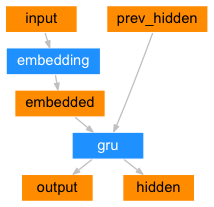

In [ ]:
class EncoderRNN(nn.Module):

    def __init__(self, input_size, hidden_size):

        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)


    def forward(self, input, hidden):
        
        output = self.embedding(input).view(1, 1, -1)
        output, hidden = self.gru(output, hidden)
        return output, hidden


    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

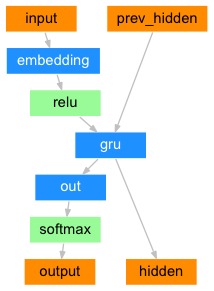

In [ ]:
class DecoderRNN(nn.Module):

    def __init__(self, hidden_size, output_size):

        super().__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(output_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)


    def forward(self, input, hidden, _):
        
        output = self.embedding(input).view(1, 1, -1)
        output = F.relu(output)
        output, hidden = self.gru(output, hidden)
        output = self.softmax(self.out(output[0]))
        return output, hidden, 0


    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

## Training loop

Training encoder-decoder models isn't that different from any other models: sample batches, compute loss, perform backpropagation and update parameters. For training use `torch.nn.NLLLoss`. Please note that the loss calculations should not include the padding token (for ignoring specific labels please look at `torch.nn.NLLLoss` documentation).


> While training, we break both encoding and decoding loops on a padding token. For encoding this assures that last hidden states are from the last digits, and for decoding we avoid calculating loss on padding tokens, as advised.

> The PyTorch `sec2sec` tutorial has `teacher_forcing` mode when the decoder is fed with a target symbol instead of its own prediction. We'll try both options and compare the results.

> The NLL loss is normalized to the decoder output length so short and long outputs influence loss equally. The optimizer is Stochastic Gradient Descent, and the learning rate is $0.01$.

In [ ]:
# <implement training loop>

def train(input_tensor, target_tensor, encoder, decoder,
    encoder_optimizer, decoder_optimizer, criterion, teacher_forcing):

    encoder_hidden = encoder.initHidden()
    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()
    encoder_outputs = torch.zeros(MAX_LENGTH, encoder.hidden_size, device=device)

    for ei in range(input_tensor.size(0)):

        if input_tensor[ei].item() == PAD_token:
            break

        encoder_output, encoder_hidden = encoder(input_tensor[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0, 0]

    decoder_input = torch.tensor([[SOS_token]], device=device)
    decoder_hidden = encoder_hidden

    loss = 0
        
    for di in range(target_tensor.size(0)):

        decoder_output, decoder_hidden, _ = decoder(
            decoder_input, decoder_hidden, encoder_outputs)

        if decoder_input.item() == PAD_token:
            break

        loss += criterion(decoder_output, target_tensor[di])

        if teacher_forcing:

            # teacher forcing: feed the target as the next input
            decoder_input = target_tensor[di] 

        else:
            # without teacher forcing: use its own predictions as the next input
            _, topi = decoder_output.topk(1)

            # detach from history as input
            decoder_input = topi.squeeze().detach()

    loss = loss / (di+1)
    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item()

In [ ]:
def asMinutes(s):
    m = s // 60
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / percent
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))
    
def showPlot(points):
    
    plt.figure()
    fig, ax = plt.subplots()

    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

In [ ]:
def trainIters(encoder, decoder, pairs, n_iters, print_every=1000, plot_every=100,
    learning_rate=0.01, teacher_forcing=True):

    start = time.time()
    plot_losses = []

    # reset every `print_every`
    print_loss_total = 0

    # plot every `plot_every`
    plot_loss_total = 0

    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
    training_pairs = [
        tensorsFromPair(pairs[p]) for p in np.random.choice(range(len(pairs)), size=n_iters)]

    criterion = nn.NLLLoss()

    for iter in range(1, n_iters + 1):

        training_pair = training_pairs[iter - 1]
        input_tensor = training_pair[0]
        target_tensor = training_pair[1]

        loss = train(input_tensor, target_tensor, encoder, decoder,
            encoder_optimizer, decoder_optimizer, criterion, teacher_forcing)
        print_loss_total += loss
        plot_loss_total += loss

        if iter % print_every == 0:

            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (
                timeSince(start, iter / n_iters), iter, iter / n_iters * 100, print_loss_avg))

        if iter % plot_every == 0:

            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

    print()
    showPlot(plot_losses);

In [ ]:
def evaluate(encoder, decoder, sentence):

    with torch.no_grad():
        input_tensor = tensorFromSentence(sentence)
        encoder_hidden = encoder.initHidden()
        encoder_outputs = torch.zeros(MAX_LENGTH, encoder.hidden_size, device=device)

        for ei in range(input_tensor.size()[0]):
            if input_tensor[ei].item() == PAD_token:
                break
            encoder_output, encoder_hidden = encoder(input_tensor[ei], encoder_hidden)
            encoder_outputs[ei] = encoder_output[0, 0]

        decoder_input = torch.tensor([[SOS_token]], device=device)
        decoder_hidden = encoder_hidden
        decoded_words = []
        decoder_attentions = torch.zeros(MAX_LENGTH, MAX_LENGTH)

        for di in range(MAX_LENGTH):

            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            decoder_attentions[di] = decoder_attention
            topv, topi = decoder_output.topk(1)

            decoded_words.append(vocab_r[topi.item()])
            if topi.item() == PAD_token:
                break
                
            decoder_input = topi.squeeze().detach()

        return decoded_words, decoder_attentions[:di+1, :ei+1]

In [ ]:
def showAttention(input_sentence, output_words, attentions):

    # set up figure with colorbar
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions.numpy(), cmap='viridis')
    fig.colorbar(cax)

    # set up axes
    ax.set_xticklabels(['', 'B', *input_sentence.ljust(MAX_LENGTH - 1, 'P')])
    ax.set_yticklabels(['B'] + output_words)

    # show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()


def train_evaluate(encoder, attn_decoder, show_attn, input, value=None):

    output_words, attentions = evaluate(encoder, attn_decoder, input)
    print('>', input)
    if value is not None:
        print('=', value)
    print('<', ''.join(output_words))
    if show_attn:
        showAttention(input, output_words, attentions)
    print()


def validate(encoder, decoder, show_attn=False, n_val=10):
    train_evaluate(encoder, decoder, show_attn, '1+1000')
    for p in np.random.choice(range(len(train_set)), n_val):
        train_evaluate(encoder, decoder, show_attn, *train_set[p])

> We use hidden size $1024$ as a tradeoff between learning potential and computation time.

In [ ]:
emb_size = 15
hidden_size = 1024

> First we train the simple model on a $10\%$ of the dataset with and without teacher forcing.

0m 18s (- 2m 44s) (1000 10%) 1.6240
0m 36s (- 2m 24s) (2000 20%) 1.5395
0m 53s (- 2m 5s) (3000 30%) 1.5203
1m 11s (- 1m 47s) (4000 40%) 1.5114
1m 29s (- 1m 29s) (5000 50%) 1.5004
1m 47s (- 1m 11s) (6000 60%) 1.4870
2m 5s (- 0m 53s) (7000 70%) 1.4641
2m 23s (- 0m 35s) (8000 80%) 1.4862
2m 41s (- 0m 17s) (9000 90%) 1.4667
3m 0s (- 0m 0s) (10000 100%) 1.4601



<Figure size 432x288 with 0 Axes>

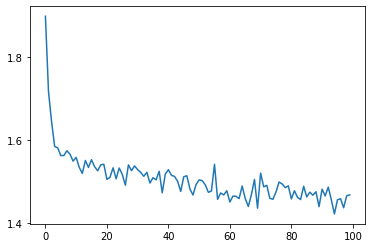

In [ ]:
encoder0 = EncoderRNN(emb_size, hidden_size).to(device)
attn_decoder0 = DecoderRNN(hidden_size, emb_size).to(device)

n_train = len(train_set) // 10
# n_train = 1
trainIters(encoder0, attn_decoder0, train_set, n_train, print_every=1000, teacher_forcing=False)

0m 19s (- 2m 53s) (1000 10%) 1.6254
0m 38s (- 2m 32s) (2000 20%) 1.5359
0m 57s (- 2m 13s) (3000 30%) 1.5204
1m 16s (- 1m 54s) (4000 40%) 1.5052
1m 34s (- 1m 34s) (5000 50%) 1.4824
1m 53s (- 1m 15s) (6000 60%) 1.4342
2m 12s (- 0m 56s) (7000 70%) 1.4217
2m 31s (- 0m 37s) (8000 80%) 1.4128
2m 50s (- 0m 18s) (9000 90%) 1.4085
3m 9s (- 0m 0s) (10000 100%) 1.4087



<Figure size 432x288 with 0 Axes>

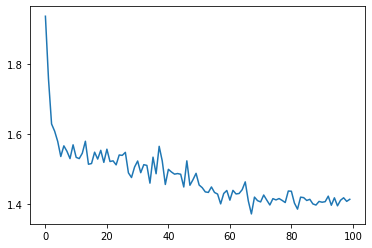

In [ ]:
encoder1 = EncoderRNN(emb_size, hidden_size).to(device)
attn_decoder1 = DecoderRNN(hidden_size, emb_size).to(device)

n_train = len(train_set) // 10
# n_train = 1
trainIters(encoder1, attn_decoder1, train_set, n_train, print_every=1000, teacher_forcing=True)

> We see that teacher forcing improved learning speed. Let's check some calculations.

In [ ]:
validate(encoder1, attn_decoder1)

> 1+1000
< B110P

> 6267+4
= 6271
< B99P

> 723*691
= 499593
< B11222P

> 3857-4794
= -937
< B-499P

> 92-316
= -224
< B-121P

> 92-240
= -148
< B-121P

> 89-6346
= -6257
< B-499P

> 8773*4468
= 39197764
< B4499P

> 871*7080
= 6166680
< B11000P

> 9339-7
= 9332
< B99P

> 3370+8
= 3378
< B99P



> The calculation results are very basic. The model predicts the sign correctly, but the number of symbols and values are off by a wide margin.

## Adding Attention Layer

Here you need to implement a layer that computes a simple additive attention:

Given encoder sequence $ h^e_0, h^e_1, h^e_2, ..., h^e_T$ and a single decoder state $h^d$,

* Compute logits with a 2-layer neural network
$$a_t = linear_{out}(tanh(linear_{e}(h^e_t) + linear_{d}(h_d)))$$
* Get probabilities from logits, 
$$ p_t = {{e ^ {a_t}} \over { \sum_\tau e^{a_\tau} }} $$

* Add up encoder states with probabilities to get __attention response__
$$ attn = \sum_t p_t \cdot h^e_t $$

> Next we add the decoder with an additive attention. Additionally, the dropout is included for better generalization.

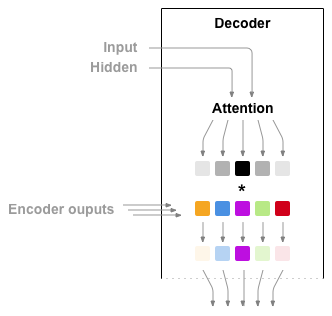

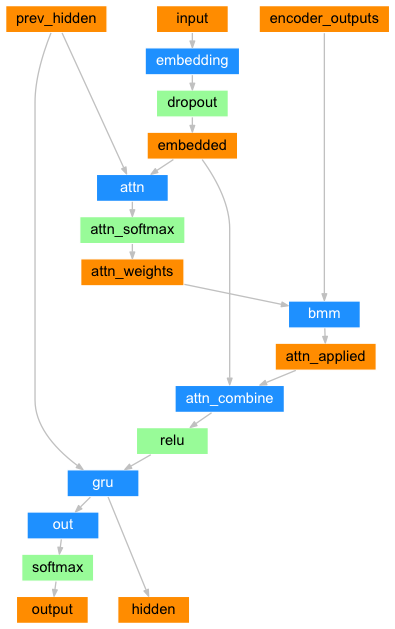

In [ ]:
# <implement attention layer>
# <add attention layer for your seq2seq model>
# <train the two models (with/without attention and compare the results)

class AttnDecoderRNN(nn.Module):

    def __init__(self, hidden_size, output_size, dropout_p=0.1, max_length=MAX_LENGTH):

        super().__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length

        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.attn = nn.Linear(self.hidden_size * 2, self.max_length)
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)


    def forward(self, input, hidden, encoder_outputs):
        
        embedded = self.embedding(input).view(1, 1, -1)
        embedded = self.dropout(embedded)

        attn_weights = F.softmax(
            self.attn(torch.cat((embedded[0], hidden[0]), 1)), dim=1)
        attn_applied = torch.bmm(
            attn_weights.unsqueeze(0), encoder_outputs.unsqueeze(0))

        output = torch.cat((embedded[0], attn_applied[0]), 1)
        output = self.attn_combine(output).unsqueeze(0)
        output = F.relu(output)
        output, hidden = self.gru(output, hidden)
        output = F.log_softmax(self.out(output[0]), dim=1)

        return output, hidden, attn_weights


    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

> Again we train on the $10\%$ of the data.

0m 23s (- 3m 35s) (1000 10%) 1.6365
0m 47s (- 3m 9s) (2000 20%) 1.4693
1m 10s (- 2m 44s) (3000 30%) 1.4123
1m 34s (- 2m 21s) (4000 40%) 1.3860
1m 57s (- 1m 57s) (5000 50%) 1.3642
2m 20s (- 1m 33s) (6000 60%) 1.3507
2m 43s (- 1m 10s) (7000 70%) 1.3347
3m 7s (- 0m 46s) (8000 80%) 1.3292
3m 30s (- 0m 23s) (9000 90%) 1.3099
3m 53s (- 0m 0s) (10000 100%) 1.3150



<Figure size 432x288 with 0 Axes>

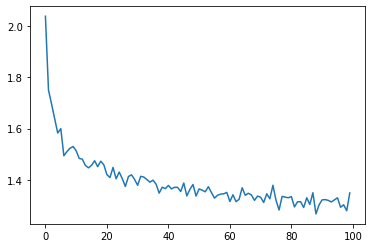

In [ ]:
encoder2 = EncoderRNN(emb_size, hidden_size).to(device)
attn_decoder2 = AttnDecoderRNN(hidden_size, emb_size, dropout_p=0.0).to(device)

n_train = len(train_set) // 10
# n_train = 1
trainIters(encoder2, attn_decoder2, train_set, n_train, print_every=1000, teacher_forcing=True)

In [ ]:
validate(encoder2, attn_decoder2, False)

> 1+1000
< B100P

> 8*5001
= 40008
< B15599P

> 29+559
= 588
< B559P

> 5559+4
= 5563
< B5999P

> 77+570
= 647
< B559P

> 46+400
= 446
< B499P

> 512*85
= 43520
< B11299P

> 6554*7333
= 48060482
< B-2559999P

> 2817+5467
= 8284
< B1599P

> 7*2507
= 17549
< B15559P

> 6678-77
= 6601
< B-6999P



> There's no progress so far. Let's train the model with attention on the full dataset, with the teacher forcing and $0.1$ dropout.

0m 28s (- 46m 51s) (1000 1%) 1.6261
0m 52s (- 42m 38s) (2000 2%) 1.4712
1m 15s (- 40m 53s) (3000 3%) 1.4238
1m 39s (- 39m 47s) (4000 4%) 1.3792
2m 3s (- 38m 57s) (5000 5%) 1.3636
2m 26s (- 38m 17s) (6000 6%) 1.3491
2m 50s (- 37m 41s) (7000 7%) 1.3420
3m 13s (- 37m 9s) (8000 8%) 1.3370
3m 37s (- 36m 39s) (9000 9%) 1.3250
4m 1s (- 36m 9s) (10000 10%) 1.3169
4m 24s (- 35m 40s) (11000 11%) 1.3111
4m 47s (- 35m 11s) (12000 12%) 1.3051
5m 11s (- 34m 43s) (13000 13%) 1.2899
5m 34s (- 34m 15s) (14000 14%) 1.2928
5m 58s (- 33m 49s) (15000 15%) 1.2831
6m 21s (- 33m 23s) (16000 16%) 1.2810
6m 44s (- 32m 57s) (17000 17%) 1.2775
7m 8s (- 32m 30s) (18000 18%) 1.2661
7m 31s (- 32m 5s) (19000 19%) 1.2543
7m 54s (- 31m 39s) (20000 20%) 1.2384
8m 18s (- 31m 14s) (21000 21%) 1.2454
8m 41s (- 30m 49s) (22000 22%) 1.2465
9m 4s (- 30m 24s) (23000 23%) 1.2159
9m 28s (- 29m 59s) (24000 24%) 1.2353
9m 51s (- 29m 35s) (25000 25%) 1.2294
10m 15s (- 29m 10s) (26000 26%) 1.2196
10m 38s (- 28m 46s) (27000 27%) 1.20

<Figure size 432x288 with 0 Axes>

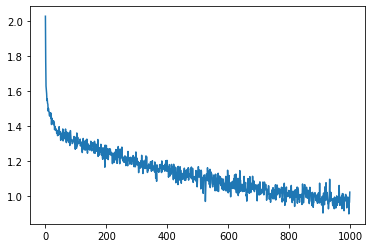

In [ ]:
encoder3 = EncoderRNN(emb_size, hidden_size).to(device)
attn_decoder3 = AttnDecoderRNN(hidden_size, emb_size, dropout_p=0.1).to(device)

n_train = len(train_set)
trainIters(encoder3, attn_decoder3, train_set, n_train, print_every=1000, teacher_forcing=True)

> 1+1000
< B100P


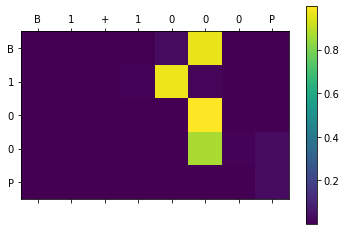


> 7097-2971
= 4126
< B5599P


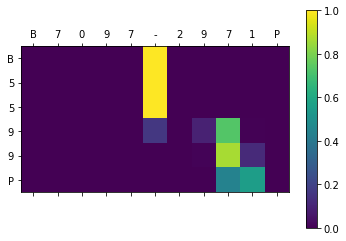


> 8817-67
= 8750
< B9999P


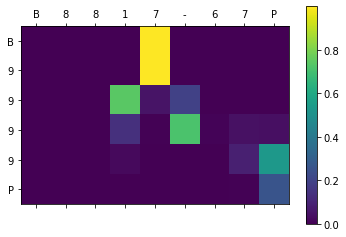


> 988*1827
= 1805076
< B1999999P


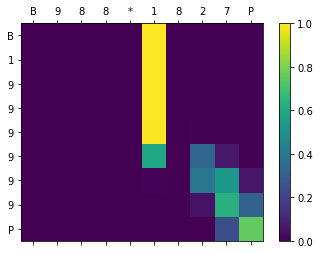


> 5012*3976
= 19927712
< B19999944P


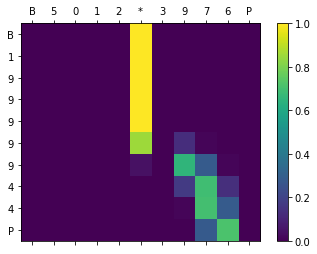


> 5*7712
= 38560
< B39990P


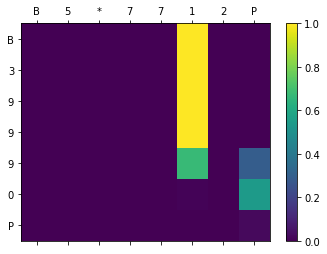


> 961*61
= 58621
< B59949P


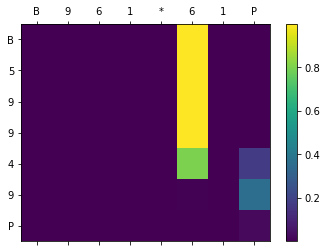


> 4*7848
= 31392
< B29994P


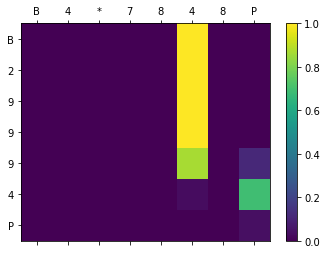


> 309+2507
= 2816
< B3199P


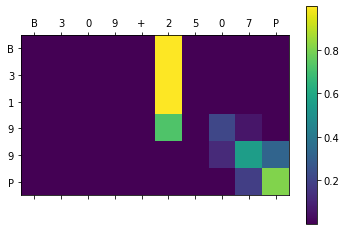


> 7094*295
= 2092730
< B2999950P


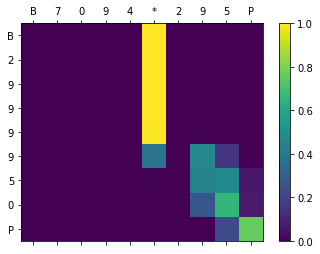


> 3094+87
= 3181
< B3199P


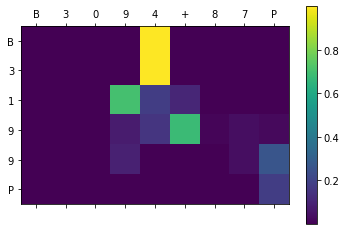

In [ ]:
validate(encoder3, attn_decoder3, True)

> The extended training lowered the loss and brought some improvements in the calculation results. Number of symbols in the result is mostly correct, $6$ of $10$ examples have the correct first digit, but the model still struggles with long results by tossing $9$s.

> As a bonus the `sec2sec` tutorial visualizes the attention matrices, which demonstrates absence of attention to the start of inputs, despite the fact that they are obviously equally important.